# **Лабораторна робота №1 з дисципліни "Штучні нейронні мережі"**

### Виконав Чистяков Данило

##### Для виконання обрав датасет із кредитними істоіями користувачів для класифікації їх за знакою credit_score

In [7]:
# IMPORTS
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler,  OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'distutils'

### Імпорт датасету

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_History_Age_Months,Credit_Score
0,23.0,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,...,Good,809.98,26.822620,No,49.574949,118.280222,High_spent_Small_value_payments,312.494089,265,Good
1,23.0,Scientist,19114.12,1824.843333,3,4,3,4,1,1.0,...,Good,809.98,31.944960,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,265,Good
2,23.0,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,...,Good,809.98,28.609352,No,49.574949,118.280222,Low_spent_Medium_value_payments,331.209863,267,Good
3,23.0,Scientist,19114.12,1824.843333,3,4,3,4,5,4.0,...,Good,809.98,31.377862,No,49.574949,118.280222,Low_spent_Small_value_payments,223.451310,268,Good
4,23.0,Scientist,19114.12,1824.843333,3,4,3,4,6,1.0,...,Good,809.98,24.797347,No,49.574949,118.280222,High_spent_Medium_value_payments,341.489231,269,Good


In [3]:
df["Credit_Score"] = LabelEncoder().fit_transform(df["Credit_Score"])
df["Credit_Score"]

0        0
1        0
2        0
3        0
4        0
        ..
91091    1
91092    1
91093    1
91094    2
91095    1
Name: Credit_Score, Length: 91096, dtype: int32

In [4]:
df['Credit_Score'].value_counts()


Credit_Score
2    48649
1    26397
0    16050
Name: count, dtype: int64

<Axes: >

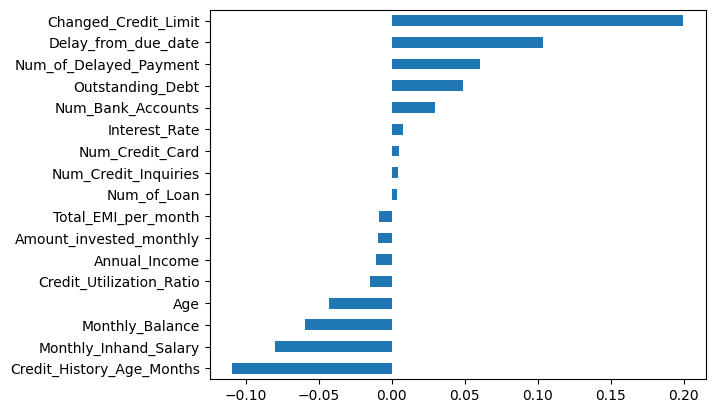

In [5]:
numerical_df = df.select_dtypes(include=[np.number])

correlation_series = numerical_df.corr()['Credit_Score'][:-1].sort_values()
correlation_series.plot.barh()

In [6]:
df.select_dtypes(include=['object']).columns

Index(['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
       'Payment_Behaviour'],
      dtype='object')

In [7]:
payment_behaviour_categories = ['Low_spent_Small_value_payments',
                                'Low_spent_Medium_value_payments',
                                'Low_spent_Large_value_payments',
                                'High_spent_Small_value_payments',
                                'High_spent_Medium_value_payments',
                                'High_spent_Large_value_payments']

payment_behaviour_encoder = OrdinalEncoder(categories=[payment_behaviour_categories])

df['Payment_Behaviour'] = payment_behaviour_encoder.fit_transform(df[['Payment_Behaviour']])

In [8]:
label_encoder = OrdinalEncoder()
df['Credit_Mix'] = label_encoder.fit_transform(df[['Credit_Mix']])

In [9]:
label_encoder = LabelEncoder()
df['Payment_of_Min_Amount'] = label_encoder.fit_transform(df['Payment_of_Min_Amount'])

In [10]:
label_encoder = LabelEncoder()
df['Occupation'] = label_encoder.fit_transform(df['Occupation'])

In [11]:
df.shape

(91096, 22)

In [12]:
X = df.drop("Credit_Score", axis=1)
y = df.Credit_Score

In [13]:
y.value_counts(normalize=True)

Credit_Score
2    0.534041
1    0.289771
0    0.176188
Name: proportion, dtype: float64

In [14]:
smote = SMOTE()
X, y = smote.fit_resample(X,y)

In [15]:
y.value_counts()

Credit_Score
0    48649
2    48649
1    48649
Name: count, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    stratify=y, random_state=42)

In [17]:
df["Credit_Score"].value_counts()

Credit_Score
2    48649
1    26397
0    16050
Name: count, dtype: int64

In [18]:
y_train.value_counts()

Credit_Score
0    41352
1    41351
2    41351
Name: count, dtype: int64

# Normalization

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)
    
    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [21]:
model_batchN = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'), 
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(3, activation='softmax')
])
model_batchN.compile(optimizer = Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=70,
                               restore_best_weights=True)

model_batchN.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          validation_split=0.1,
          batch_size=512,
          epochs=75,
          verbose=1,
          callbacks=[early_stopping])

w:\University\Artifical_intellegence_systems\AISVenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6086 - loss: 0.9795 - val_accuracy: 0.7225 - val_loss: 0.7125
Epoch 2/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7124 - loss: 0.7368 - val_accuracy: 0.7301 - val_loss: 0.6761
Epoch 3/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7251 - loss: 0.6982 - val_accuracy: 0.7383 - val_loss: 0.6589
Epoch 4/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7291 - loss: 0.6815 - val_accuracy: 0.7408 - val_loss: 0.6503
Epoch 5/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7312 - loss: 0.6681 - val_accuracy: 0.7425 - val_loss: 0.6393
Epoch 6/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7375 - loss: 0.6566 - val_accuracy: 0.7434 - val_loss: 0.6348
Epoch 7/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7402 - loss: 0.6525 - val_accuracy: 0.7454 - val_loss: 0.6283
Epoch 8/75
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7414 - loss: 0.6444 - val_accu

### Кросс-валідація

In [28]:
kfd = KFold(n_splits=5, shuffle=True, random_state=17)

fold_no = 1
for train_index, val_index in kfd.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = y.iloc[train_index], y.iloc[val_index]

    model_batchN = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'), 
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(3, activation='softmax')
    ])
    model_batchN.compile(optimizer = Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=70,
                               restore_best_weights=True)

    model_batchN.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=1)

    scores = model_batchN.evaluate(X_val, Y_val, verbose=0)

    print(f"Результати для фолду {fold_no}: {model_batchN.metrics_names[1]} = {scores[1] * 100}%")
    fold_no += 1

Epoch 1/5


w:\University\Artifical_intellegence_systems\AISVenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3649/3649 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.4902 - loss: 1.0424
Epoch 2/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5680 - loss: 0.8839
Epoch 3/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5899 - loss: 0.8699
Epoch 4/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5928 - loss: 0.8676
Epoch 5/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5990 - loss: 0.8574
Результати для фолду 1: compile_metrics = 53.532034158706665%
Epoch 1/5


w:\University\Artifical_intellegence_systems\AISVenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3649/3649 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.4928 - loss: 1.0435
Epoch 2/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5657 - loss: 0.8859
Epoch 3/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5793 - loss: 0.8756
Epoch 4/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5911 - loss: 0.8656
Epoch 5/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6001 - loss: 0.8575
Результати для фолду 2: compile_metrics = 50.66460967063904%
Epoch 1/5


w:\University\Artifical_intellegence_systems\AISVenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3649/3649 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.4914 - loss: 1.0402
Epoch 2/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5661 - loss: 0.8841
Epoch 3/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5832 - loss: 0.8738
Epoch 4/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5939 - loss: 0.8626
Epoch 5/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5938 - loss: 0.8611
Результати для фолду 3: compile_metrics = 63.0477249622345%
Epoch 1/5


w:\University\Artifical_intellegence_systems\AISVenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3649/3649 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.4878 - loss: 1.0450
Epoch 2/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5679 - loss: 0.8852
Epoch 3/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5787 - loss: 0.8756
Epoch 4/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5925 - loss: 0.8656
Epoch 5/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5891 - loss: 0.8630
Результати для фолду 4: compile_metrics = 60.687243938446045%
Epoch 1/5


w:\University\Artifical_intellegence_systems\AISVenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3649/3649 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5013 - loss: 1.0206
Epoch 2/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5684 - loss: 0.8851
Epoch 3/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5797 - loss: 0.8745
Epoch 4/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5935 - loss: 0.8622
Epoch 5/5
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6020 - loss: 0.8535
Результати для фолду 5: compile_metrics = 59.10788178443909%
